In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import os
import pandas as pd
import math
import seaborn as sns

from scipy.special import logsumexp
from pathlib import Path
from tqdm.auto import tqdm, trange

from bge_score_jax import BGe

/home/zj448/.conda/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']

galtypes = ['ell','len','spr']
typename = {'ell':'E','len':'S0','spr':'S'}


edge_marginal_array={}
path_marginal_array={}

for type in galtypes:
    edge_marginal_array[type]=np.load(f'edge_marginal_LOO_{type}.npy')
    path_marginal_array[type]=np.load(f'path_marginal_LOO_{type}.npy')

In [12]:
def plot_marginals(marginals, path=False):
    plt.figure(figsize=(36, 10))
    #cmap = cmr.neutral
    cmap='gray'

    for i, galtype in enumerate(galtypes):
        marginal=marginals[galtype]
        ax = plt.subplot(1,3,i+1)
        marginal_mean=marginal.mean(axis=0)
        marginal_std=marginal.std(axis=0)
        annot=np.empty((marginal.shape[1],marginal.shape[1]), dtype=object)

        for j in range(marginal.shape[1]):
            for k in range(marginal.shape[1]):
                annot[j,k]=str(round(marginal_mean[j,k],2))+r'$\pm$'+str(round(marginal_std[j,k],2))
        
        sns.heatmap(marginal.mean(axis=0), cmap=cmap, ax=ax,
                    annot=annot, annot_kws={"fontsize":15,'rotation':30}, fmt='', cbar=False)
        
        # for j in range(marginal.shape[1]):
        #     for k in range(marginal.shape[1]):
        #         ax.text(k+0.70,j+0.52,r'$\pm$'+str(round(marginal_std[j,k],2)),color='red',fontsize=18,fontweight='bold') #C9
        ax.set_title(typename[galtype],fontsize=35)
        ax.set_xticklabels(labels_list,rotation=45,fontsize=20)
        ax.set_yticklabels(labels_list,rotation=0,fontsize=20)
        if path:
            ax.set_xlabel('Descendant',labelpad=-10,fontsize=25)
            ax.set_ylabel('Ancestor',labelpad=-35,fontsize=25)
        else:
            ax.set_xlabel('Child',labelpad=-10,fontsize=25)
            ax.set_ylabel('Parent',labelpad=-35,fontsize=25)
    #plt.savefig('figures/edge_marginals.png', dpi=300)
    plt.show()
    return None

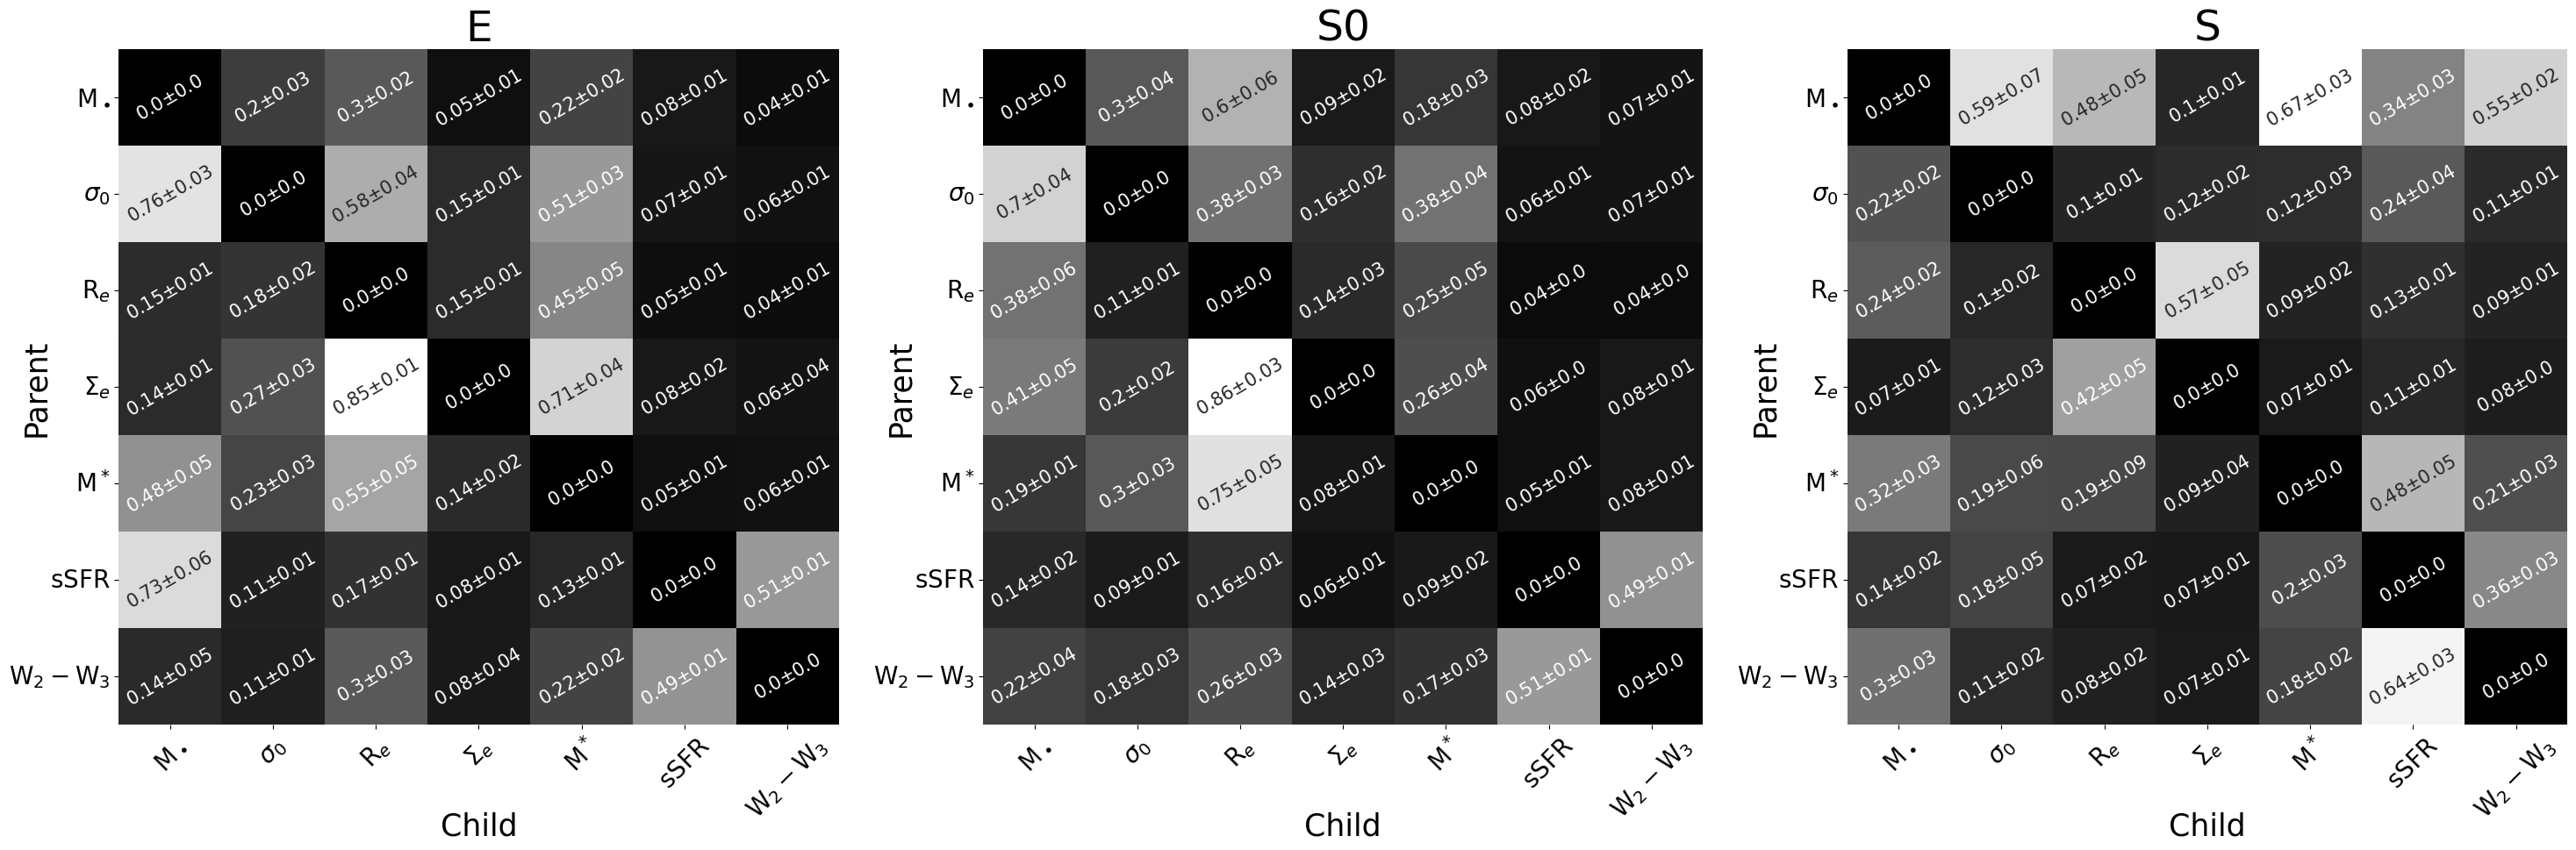

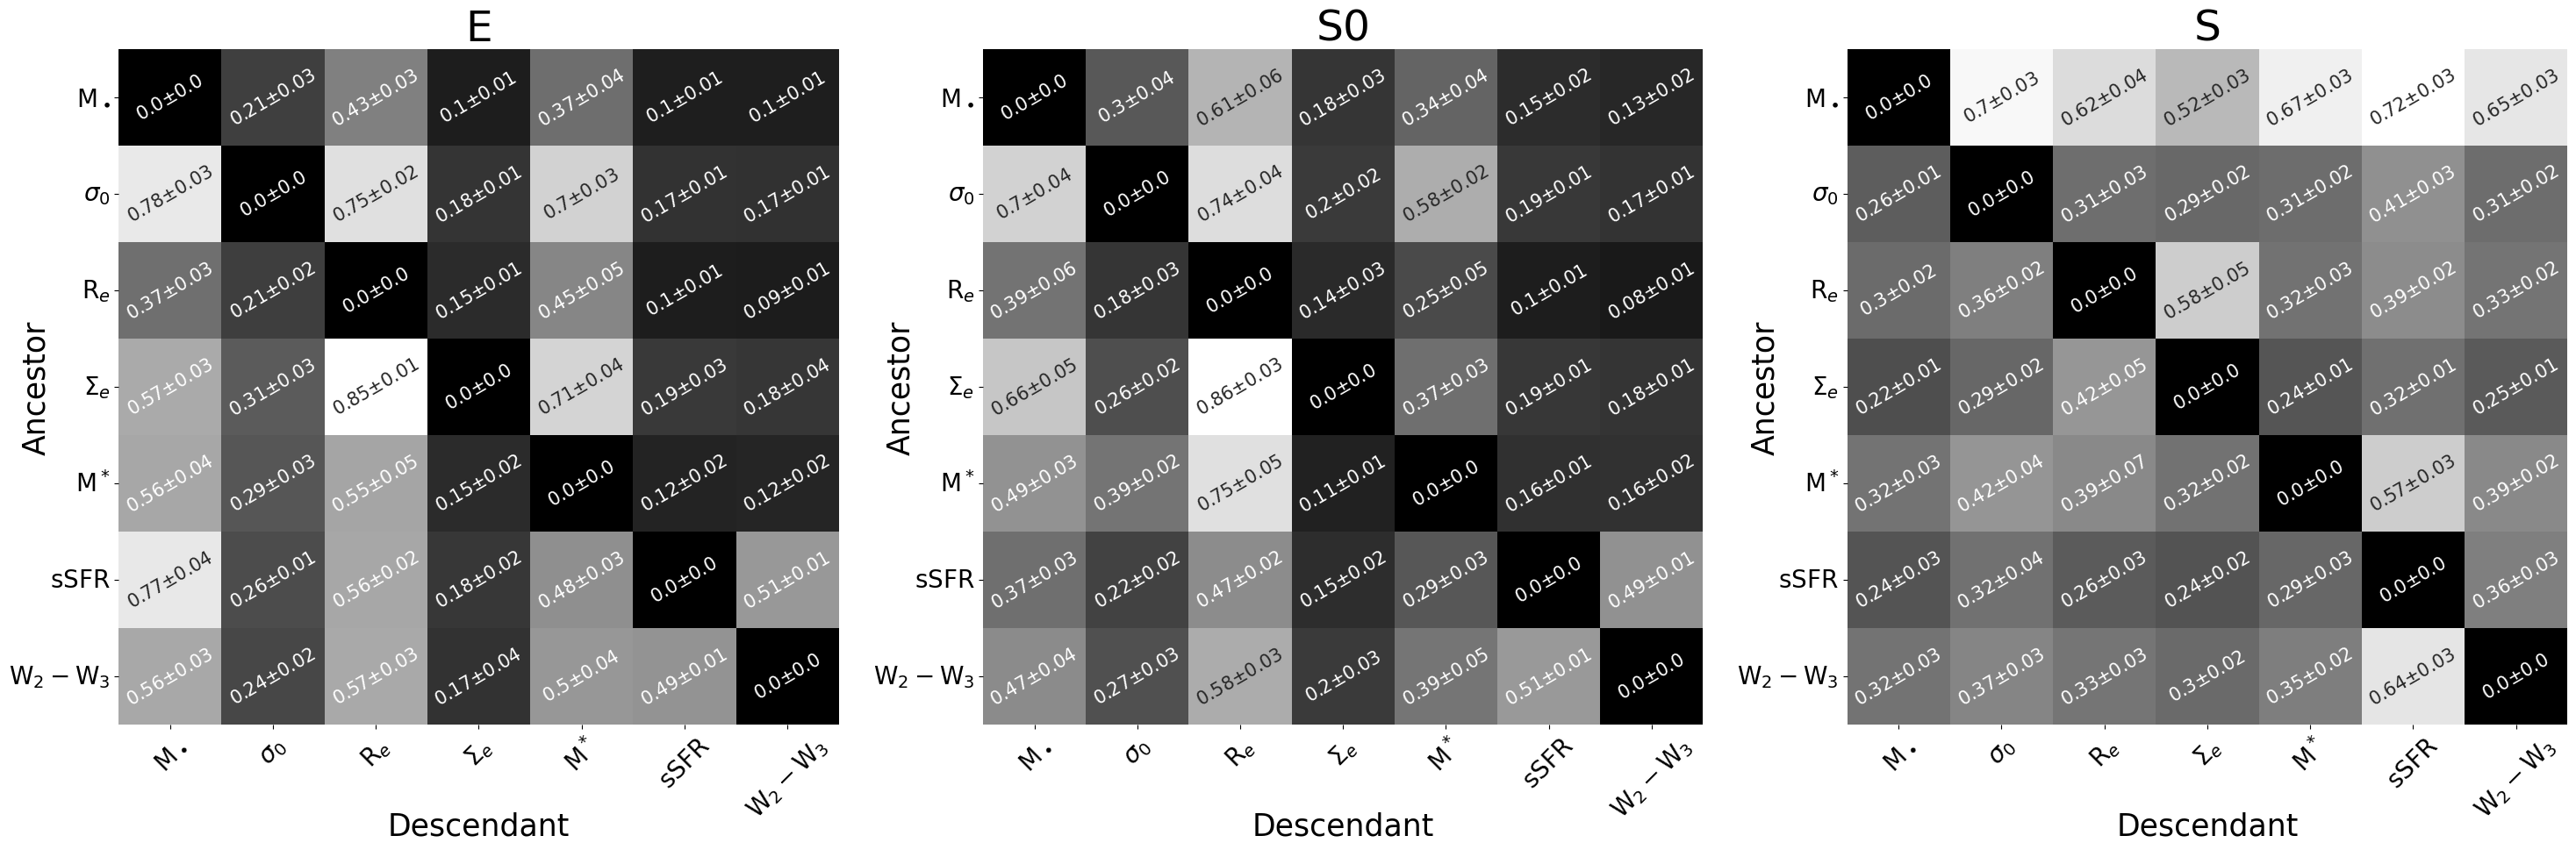

In [13]:
plot_marginals(edge_marginal_array)
plot_marginals(path_marginal_array,path=True)

In [6]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def plot_single_margin(index1,index2,marginals=edge_marginal_array,marginals2=path_marginal_array,bins=5):
    color=['C1','C2','C3']
    for i, galtype in enumerate(galtypes):
        plt.hist(marginals[galtype][:,index1,index2],alpha=0.7,bins=bins,histtype='step',lw=2,color=color[i])
        plt.hist(marginals2[galtype][:,index1,index2],alpha=0.7,bins=bins,histtype='step',lw=2,ls='--',color=color[i])
    plt.xlim(0,1)


    # Create custom legend entries
    legend_colors = [mpatches.Patch(edgecolor=color[i],fill=False,lw=2,label=typename[galtypes[i]],alpha=0.7) for i in range(len(typename))]
    legend_lines = [mlines.Line2D([], [], color='black', linewidth=2, linestyle=style,alpha=0.7, label=label) for style, label in [('-', 'Edge Marginals'), ('--', 'Path Marginals')]]

    # Combine legend entries and specify layout
    plt.legend(handles=legend_colors + legend_lines, loc=0,fontsize=10)
    plt.xlabel('marginals')
    plt.ylabel('counts')
    plt.title(labels_list[index1]+' --> '+labels_list[index2],fontsize=15)

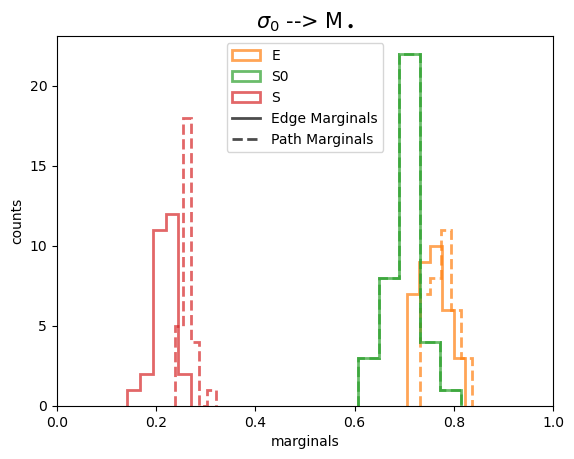

In [16]:
plot_single_margin(1,0,edge_marginal_array)

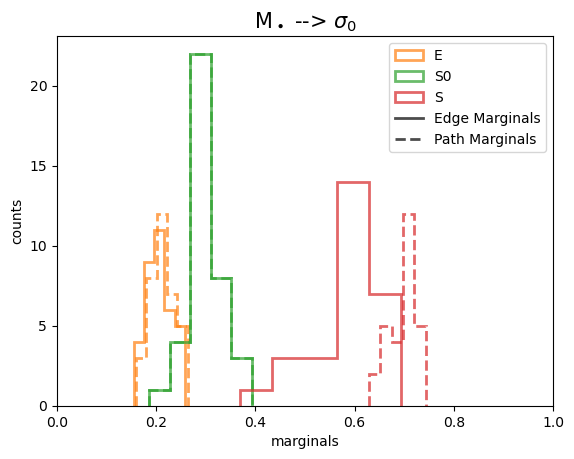

In [17]:
plot_single_margin(0,1,edge_marginal_array)

In [7]:
diff=edge_marginal_array['spr']-edge_marginal_array['spr'].mean(axis=0)
diff.shape
signal=edge_marginal_array['spr']

In [43]:
print(np.abs(diff[:,1,0]).max(),np.abs(diff[:,0,1]).max())
print(np.abs(diff[:,1,0]).argmax(),np.abs(diff[:,0,1]).argmax())

0.07568865216204099 0.2234971917101315
24 24


In [ ]:
# NGC 4826

In [10]:
#diff[:,0,1].argsort()
signal[:,0,1].argsort()

array([24, 10,  5,  4, 18, 21,  0, 22, 14, 23, 13, 15, 11,  8, 27, 25,  7,
        6, 19, 17,  2,  3, 20,  1,  9, 16, 26, 12])

In [11]:
np.sort(signal[:,0,1])

array([0.36847052, 0.43614578, 0.48621044, 0.49749431, 0.53453225,
       0.55499047, 0.56180042, 0.5649609 , 0.56934017, 0.59803057,
       0.60692644, 0.60759938, 0.60915631, 0.6095916 , 0.61263561,
       0.61469561, 0.61771232, 0.6178894 , 0.61799484, 0.62009811,
       0.62828028, 0.63746166, 0.64156651, 0.64866966, 0.65572786,
       0.67575389, 0.68757051, 0.69379008])

In [13]:
df_withname=pd.read_csv('R_e_data/causal_BH_spr_withname.csv')
df_full = pd.read_csv('R_e_data/SMBH_Data_03_15_24v2.csv',header=1)

In [14]:
names=df_withname['Galaxy'][signal[:,0,1].argsort()]
names

24    NGC 4826
10    NGC 2974
5     NGC 1300
4     NGC 1097
18    NGC 4303
21    NGC 4594
0     Circinus
22    NGC 4699
14    NGC 3368
23    NGC 4736
13    NGC 3227
15    NGC 3627
11    NGC 3031
8     NGC 2273
27    UGC 3789
25    NGC 4945
7     NGC 1398
6     NGC 1320
19    NGC 4388
17    NGC 4258
2     NGC 0224
3     NGC 0253
20    NGC 4501
1      IC 2560
9     NGC 2960
16    NGC 4151
26    NGC 7582
12    NGC 3079
Name: Galaxy, dtype: object

In [15]:
idx=np.zeros(len(names))
for i,name in enumerate(names):
    idx[i]=np.arange(len(df_full))[df_full['Galaxy']==name]

/tmp/ipykernel_1835410/3866956219.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx[i]=np.arange(len(df_full))[df_full['Galaxy']==name]


In [16]:
df_spr=df_full.iloc[idx].copy()

In [21]:
df_spr['signal']=np.sort(signal[:,0,1])
df_spr[['Galaxy','Leda Type','T-type','AGN','B/T','phi','GJC23log(sSFR)','bvtc','signal']]

,Galaxy,Leda Type,T-type,AGN,B/T,phi,GJC23log(sSFR),bvtc,signal
134,NGC 4826,SABa,2.2,1.0,0.138038,24.3,-10.681944,0.742,0.368471
117,NGC 2974,E,-4.3,1.0,0.316228,10.5,-11.275546,0.929,0.436146
108,NGC 1300,Sbc,4.0,0.0,0.134896,12.7,-10.405089,0.586,0.486210
107,NGC 1097,SBb,3.3,1.0,0.263027,9.5,-10.039920,0.676,0.497494
127,NGC 4303,Sbc,4.0,1.0,0.087096,14.7,-9.864102,0.493,0.534532
131,NGC 4594,Sa,1.1,1.0,0.602560,5.2,-11.545452,0.878,0.554990
96,Circinus,Sb,3.3,1.0,0.309030,17.0,-9.372612,0.916,0.561800
132,NGC 4699,SABb,2.9,0.0,0.107152,5.1,-10.857566,0.825,0.564961
121,NGC 3368,Sab,2.1,0.0,0.131826,14.0,-10.805629,0.796,0.569340
133,NGC 4736,SABa,2.3,1.0,0.331131,15.0,-10.462862,0.718,0.598031


In [18]:
low_scatter_para=['ETG','T-type','Bar', 'Disk', 'Ring', 'Core', 'Multiple', 'Compactness', 'AGN',
       'Pseudobulge', 'BCG', 'cD','M*_sph', 'M*_gal', 'log_B/T',
       'log_sigma0', 'log_R_e_sph_maj','log_R_e_sph_eq_kpc', 'log_n_sph_maj', 'log_n_sph_eq', 'log(I_e,sph,maj/M_Sun/pc^2)',
       'log(I_e,sph,eq/M_Sun/pc^2)', 'Concentration_Index',
       'avg_Rho_1kpc_Exact_All', 'r1_density_approx', 'log10(R10_kpc)',
       'logRho_R10_approx', 'log_rho10_Exact', 'log10(R90_kpc)',
       'logRho_R90_approx', 'log_rho_90_Exact_all', 'Rho_re_spatial',
       'SR_pc_All', 'Rho_SR_pc_All', 'CR_def1_approx_new',
       'Rho_cr_def1_approx_new', 'CR_def2_approx_new',
       'Rho_CR_def2_approx_new', 'Sr(pc)_2_using_Falserm_drho',
       'Log_Approx_Avg_density_10pc', 'log_Rho_e_Exact_new',
       'logRho_e_approx_New', 'logRho_soi_approx_new',
       'log_Rho_soi_exact_new', 'Avg_Rho_Re_Exact_all',
       'Avg_Rho_soi_exact_all', 'Avg_Rho_re_Exact_all', 'Rho_re_Exact_all',
       'Rho_r_soi_2BH_approx', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_Rho_10kpc_exact_final', 'Log_Avg_Rho_100pc_approx',
       'Log_Avg_Rho_5kpc_approx', 'Log_Avg_rho_5kpc_exact_all', 'ube', 'bve',
       'dc', 'bvtc', 'bri25', 'mabs', 'blum', 'logblum', 'logSigma0sph',
       'LogSigma0', 'R10', 'logR10', 'logR10phi', 'Rh', 'logRh', 'logRhphi',
       'logHalo','B-V','V-[3.6]','GJC23W1-W2','GJC23W2-W3','GJC23log(M*,gal/M_sun)',
       'GJC23log(SFR)','GJC23log(sSFR)','log<Sigma>_e','log<Sigma>_h','M_BH','phi','v_max','signal']

In [19]:
corr=df_spr[low_scatter_para].corr()['signal']

In [20]:
for i,line in enumerate(corr.sort_values()):
    print(corr.sort_values().keys()[i],line)

bvtc -0.28726463704711397
log_sigma0 -0.2182026225069131
ube -0.20202098677931501
GJC23log(M*,gal/M_sun) -0.17560556306387026
Rh -0.16225721566810664
logRh -0.14926451110117728
M_BH -0.14329425112044025
Rho_re_spatial -0.12295927999535901
Rho_re_Exact_all -0.12293236939921755
mabs -0.12277688305744444
logHalo -0.11998303336711301
CR_def2_approx_new -0.11226892716376813
Avg_Rho_re_Exact_all -0.10269185365085569
logR10phi -0.10258726622438868
AGN -0.09866829508400127
M*_gal -0.09652635600478056
B-V -0.09422723583902642
Avg_Rho_Re_Exact_all -0.08601600258276634
bve -0.08513697647882636
logRho_R90_approx -0.07218811203405053
log_rho_90_Exact_all -0.0702906308022393
r1_density_approx -0.060951618579450334
R10 -0.059331159035439285
log_R_e_sph_maj -0.05855593641170283
log10(R10_kpc) -0.04792694720985585
bri25 -0.044645058715591796
Rho_CR_def2_approx_new -0.042968771021270176
dc -0.024398698979485885
logR10 -0.015261471752767543
log_Rho_e_Exact_new -0.014474326741305861
logRho_e_approx_New -0